This tutorial simulates the erosional degradation of an earthquake fault scarp in 1D and 2D using numpy and Landlab. It solves the diffusion equation using a forward-time, centered-space finite-volume alogrithm. It is modified from the Landlab [tutorial]( https://notebooks.gesis.org/binder/jupyter/user/landlab-landlab-9tfp62l7/notebooks/notebooks/tutorials/fault_scarp/landlab-fault-scarp.ipynb).

The finite-volume solution to the 2D diffusion equation is described by the following two equations for continuity of mass and sediment flux, respectively. 

$\frac{\partial z}{\partial t} = -\nabla \cdot \mathbf{q}_s$ \
$\mathbf{q}_s = -D \nabla z$ 

where $z$ is the elevation, $t$ is time, the vector $\mathbf{q}_s$ is the volumetric soil transport rate per unit width, i.e., sediment flux, and $\nabla$ is the divergence operator. 

$\mathbf{q}_s$ depends on the slope gradient and $D$ is a transport-rate coefficient - sometimes called *hillslope diffusivity* - with dimensions of length suqared per time. 

Assuming a uniform $D$, the classical 2D diffusion equation becomes 

$\frac{\partial z}{\partial t} = -\nabla^2 z$

In 1D, the equations for the system is simplified to

$\frac{d z}{d t} = \frac{d q_s}{dx}$ \
$q_s = -D \frac{d z}{dx} $

In Part 1, we will solve the 1D eorsional degradation of an earthquake fault scarp with numpy and matplotlib. In Part 2, we show how to solve the problem in 2D with Landlab model grids. In Part 3, we show one Landlab module called LinearDiffuser. To explore the functionalities of Landlab further, you are suggested to check out https://landlab.readthedocs.io/en/latest/  

First, let's install landlab, numpy, and matplotlib if you don't have them installed.

In [2]:
#!pip install landlab numpy matplotlib 

# activate the above line if landlab, numpy and matplotlib is not installed.

## Part 1: 1D erosional degradation with numpy and matplotlib
The deformation of a 1D profile perpendicular to an earthquake fault scarp over time is simulated. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
gridSizeInMeters = 1 
x = np.arange(0, 100, gridSizeInMeters, dtype=float)
elev = np.zeros(x.shape, dtype=float)
diffusivityConst = 0.01 
elev[x>50] += 1

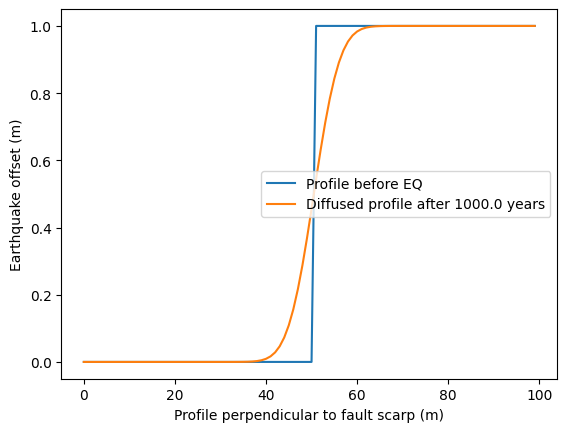

In [5]:
cfl = 0.2 # Courant-Fridrichs-Lewy condition coefficient for numerical stability
totalTimeInYears = 1e3 
timeIncrementInYears = cfl*gridSizeInMeters**2/diffusivityConst
numOfTimeSteps = int(totalTimeInYears/timeIncrementInYears)
elevBeforeEQ = elev.copy()
for i in range(numOfTimeSteps):
    flux = -diffusivityConst*np.diff(elev)/gridSizeInMeters
    dElev_dt = -np.diff(flux)/gridSizeInMeters
    elev[1:-1] += dElev_dt*timeIncrementInYears

plt.plot(x, elevBeforeEQ, label="Profile before EQ")
plt.plot(x, elev, label="Diffused profile after "+str(totalTimeInYears)+" years")
plt.xlabel('Profile perpendicular to fault scarp (m)')
plt.ylabel('Earthquake offset (m)')
plt.legend()

## Part 2: 2D erosional degradation with Landlab's Model Grids
The fault trace cuts through a 2D surface, whose deformation over time after an earthquake slip will be simulated. We will use model grids from Landlab. 

In [8]:
from landlab import RasterModelGrid, HexModelGrid
from landlab.plot.graph import plot_graph
from landlab.plot.imshow import imshow_grid
#!pip show landlab

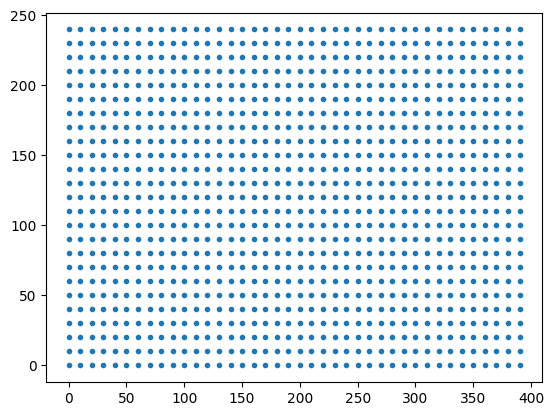

In [9]:
gridStyle = 'raster' # 'hex' or 'raster'
gridSizeInMeters = 10.

if gridStyle == 'hex':
    mesh = HexModelGrid((25,40),gridSizeInMeters, node_layout="rect")
elif gridStyle == 'raster':
    mesh = RasterModelGrid((25,40), gridSizeInMeters) # Raster for regularly spaced square grid elements.
    mesh.set_closed_boundaries_at_grid_edges(True, False, True, False) # east,north,west,south

elev = mesh.add_zeros('topographic__elevation', at='node')
# visualize the nodes in the mesh.
plt.plot(mesh.x_of_node, mesh.y_of_node, '.')

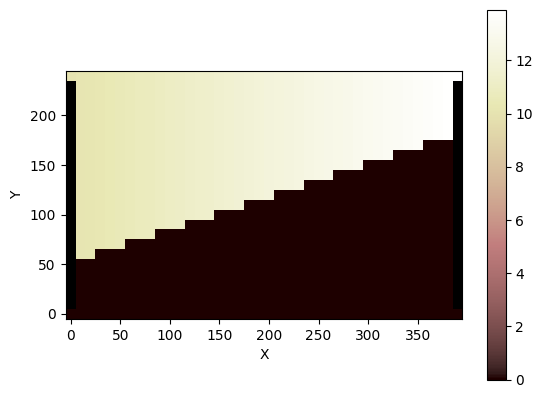

In [10]:
strike = 70.
fault_trace_y = 50.0 + np.sin(np.radians(90-strike))*mesh.x_of_node
elev[mesh.y_of_node > 
  fault_trace_y] += 10.0 + 0.01*mesh.x_of_node[mesh.y_of_node>fault_trace_y]
imshow_grid(mesh,'topographic__elevation')

Time increment in years is  2000.0
Total time in years simulated is  50000.0


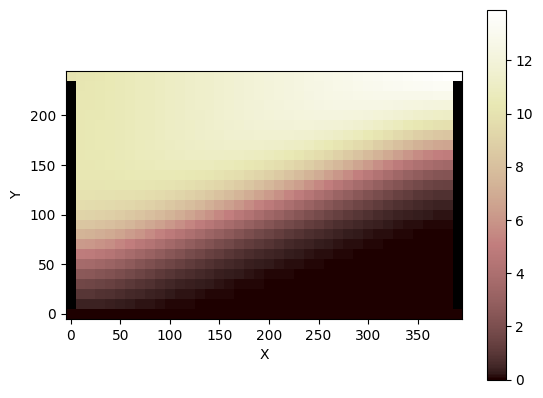

In [11]:
diffusivityConst = 0.01
timeIncrementInYears = cfl*gridSizeInMeters**2/diffusivityConst
print('Time increment in years is ', timeIncrementInYears)

flux = mesh.add_zeros('sediment_flux', at='link') # create an array for soil flux with one value at each grid link (element facet)

for i in range(25):
    grad = mesh.calc_grad_at_link(elev)
    flux[mesh.active_links] = -diffusivityConst*grad[mesh.active_links]
    dElev_dt = -mesh.calc_flux_div_at_node(flux)
    elev[mesh.core_nodes] += dElev_dt[mesh.core_nodes]*timeIncrementInYears
print('Total time in years simulated is ', (i+1)*timeIncrementInYears)

imshow_grid(mesh,'topographic__elevation')

## Part 3: using Landlab's functions
Landlab has many predefined components. For example, LinearDiffuser is a module that handles the above calculations under the time loop. 

In [12]:
from landlab.components import LinearDiffuser

In [16]:
ld = LinearDiffuser(mesh, linear_diffusivity=diffusivityConst)

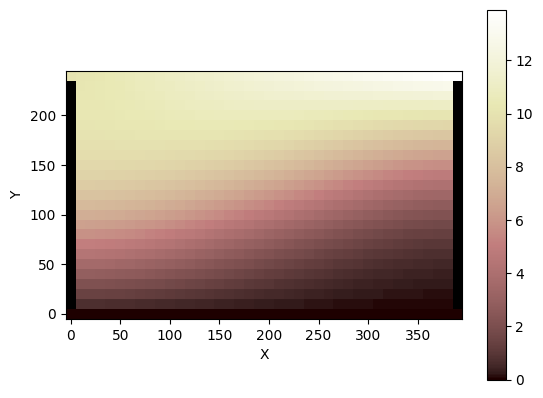

In [17]:
for i in range(25):
    ld.run_one_step(timeIncrementInYears)
imshow_grid(mesh, 'topographic__elevation')